<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction:-Trying-the-impossible!" data-toc-modified-id="Introduction:-Trying-the-impossible!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Trying the impossible!</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-MLP-model" data-toc-modified-id="Build-a-MLP-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a MLP model</a></span></li><li><span><a href="#Train-the-MLP-with-images" data-toc-modified-id="Train-the-MLP-with-images-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train the MLP with images</a></span></li></ul></div>

# Introduction: Trying the impossible!

A Convolutional Neural Network (NN) consists of two parts. A feature hierarchy with CONV and MAX-Pooling layers and a classificator on top of this feature hierarchy, usually a Multi Layer Perceptron (MLP).

But do we really need this feature hierarchy? Why not use images directly as input for a MLP? Never say never. So let's try the "impossible": learn to classify images without the feature hierarchy. Just using a MLP.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2

print( "Your NumPy version is: " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is: " + keras.__version__ )
print( "Your OpenCV version is: " + cv2.__version__ )

Using TensorFlow backend.


Your NumPy version is: 1.13.3
Your TensorFlow version is: 1.5.1
Your Keras version is: 2.2.3
Your OpenCV version is: 3.4.1


# Prepare an image provider class

In [31]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (300,300)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_images = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder", root_folder, "I found the following subfolders/classes:")
        print(class_names)
        
        nr_classes = len(class_names)
        
        for class_nr, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            for filename in filenames:
                
                teacher_vec = np.zeros( nr_classes )
                teacher_vec[class_nr] = 1.0
                
                self.all_images.append( [filename, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_images)
        print("There are {} images in total available.".format(self.nr_images))
     
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        image = image * (1.0 / 255.0)
        return image
        
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        
        image_filename  = self.all_images[rnd_idx][0]
        image_classname = self.all_images[rnd_idx][1]
        teacher_vec     = self.all_images[rnd_idx][2]
        
        image = self.load_image(image_filename)
        
        return image, image_classname, teacher_vec

Let's test the image provider class:

In [32]:
my_image_provider = image_provider( "data" )

Under folder data I found the following subfolders/classes:
['bikes', 'cars']
1344 files in subfolder data/bikes/
1307 files in subfolder data/cars/
There are 2651 images in total available.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (300, 300, 3)
teacher vec: [ 1.  0.]


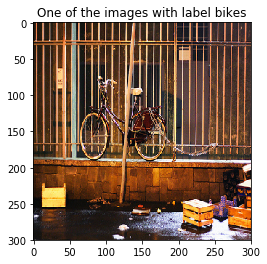

In [33]:
import matplotlib.pyplot as plt

image, label, teacher_vec = my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(label))
plt.show()

# Build a MLP model

In [34]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense
from keras import backend as K

nr_channels = 3
input_vec_dim = IMG_SIZE[0] * IMG_SIZE[1] * nr_channels
print("Input vectors for this MLP will have length", input_vec_dim)

K.clear_session()

model = Sequential()
model.add(Dense(3, activation="relu", input_dim=input_vec_dim))
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation="linear"))

model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

Input vectors for this MLP will have length 270000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 810003    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 810,029
Trainable params: 810,029
Non-trainable params: 0
_________________________________________________________________


# Train the MLP with images

In [40]:
NR_TEST_IMAGES = 500

for test_img_nr in range(0,NR_TEST_IMAGES):
    
    if test_img_nr % 100 == 0:
        print("Trained on {} train images so far...".
             format(test_img_nr))

    # Get a random image from the image provider
    image, label, teacher_vec = my_image_provider.get_random_image()
    
    # Flatten the 3D input image to a 1D input vector
    input_vec = image.flatten()
        
    #print("image has shape", image.shape)
    #print("input_vec has shape", input_vec.shape)
    #print("teacher_vec is", teacher_vec)
    #print(input_vec)
    
    input_vec = input_vec.reshape( (1, input_vec.shape[0]) )
    teacher_vec = teacher_vec.reshape( (1, teacher_vec.shape[0]) )
    #print("input_vec has shape", input_vec.shape)
    #print("teacher_vec has shape", teacher_vec.shape)
            
    model.fit(input_vec, teacher_vec, epochs=1, verbose=0)

Trained on 0 train images so far...
Trained on 100 train images so far...
Trained on 200 train images so far...
Trained on 300 train images so far...
Trained on 400 train images so far...
